In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import scipy as sc
import numpy.linalg as npl
from numpy.linalg import norm
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase

In [3]:
from ipywidgets import interactive,FloatSlider,interact

In [5]:
def manipulation_Har(func):
    def f(r_m,k):
        plt.figure(2)
        r = np.linspace(0.01, 6, num=1000)
        plt.plot(r, func(r,r_m,k))
        plt.xlim(-0.5,4)
        plt.ylim(-5,5)
        plt.show()
    return interactive(f, r_m=FloatSlider(min=0.1, max=5, step=0.2,description=r'\(r_m\)',value=1), 
                       k=FloatSlider(min=0.1,max=3.,step=0.2,description=r'\(k\)',value=2))

In [6]:
def manipulation_hist():
    def f(temperature):
        plt.figure(2)
        velocities = np.zeros((500,1))
        velocities = np.random.normal(loc=0.0, scale=np.sqrt(temperature),size=velocities.shape)
        plt.hist(velocities);
        plt.xlim(-10,10)
        plt.show()
    return interactive(f, temperature=FloatSlider(min=0.1, max=7, step=0.3,description=r'\(T\)',value=1))

In [7]:
def get_numerical_force(pot_func,r,*args):
    e_x,e_y,e_z = np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])
    h = 1e-3
    F_x = - ( pot_func(norm(r+e_x*h),*args) - pot_func(norm(r-e_x*h),*args) )  / (2*h)
    F_y = - ( pot_func(norm(r+e_y*h),*args) - pot_func(norm(r-e_y*h),*args) )  / (2*h)
    F_z = - ( pot_func(norm(r+e_z*h),*args) - pot_func(norm(r-e_z*h),*args) )  / (2*h)
    return np.array([F_x,F_y,F_z])

+ add circles on the potential
+ more details on the positions to forces
+ external functions
+ put total forces formula
+ possibility to turn on/off pieces

# Developper les fonctions pour modeliser une chaine de polymere

## get spring forces

### Potentiel harmonique

$V_{har}\,\left(d\right) = k \,\left(d-r_m\right)^2$

$\mathbf{r} = \left(x,\, y,\,  z\right)  $

$d=\sqrt{x^2+y^2+z^2}$

$\mathbf{\hat{r}}=\frac{\mathbf{r} }{d}$

In [139]:
def Potentiel_Harmonique(d,r_m,k):
    ''' '''
    return k*( d - r_m)**2

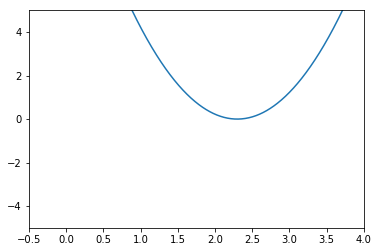

In [9]:
manipulation_Har(Potentiel_Harmonique)

## Force d'un ressort
$\mathbf{F}_{Har}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{Har}\left(d\right) =  - 2 k \, (d - r_m)  \mathbf{\hat{r}} $

$\mathbf{r} = \left(x,\, y,\,  z\right)  $

$d=\sqrt{x^2+y^2+z^2}$

$\mathbf{\hat{r}}=\frac{\mathbf{r} }{d}$

In [100]:
def Force_Harmonique(d,r_m,k):
    return  - 2*k * (d - r_m)

### tester la force avec the potentiel
$\mathbf{F}\left(\mathbf{r}\right) \approx - \left( \frac{V\left(\mathbf{r}+h_x\right) - V\left(\mathbf{r}-h_x\right)}{2h_x}, \frac{V\left(\mathbf{r}+h_y\right) - V\left(\mathbf{r}-h_y\right)}{2h_y},\frac{V\left(\mathbf{r}+h_z\right) - V\left(\mathbf{r}-h_z\right)}{2h_z} \right)  $

In [46]:
e_x,e_y,e_z = np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])
positionA,positionB,r_m,k = np.array([0,0,0]),np.array([0.9,1.3,0.99]),1.2,1.
r = positionB-positionA
d = norm(r)
h = 1e-3
F = r/d*Force_Harmonique(d,r_m,k)
F_num = get_numerical_force(Potentiel_Harmonique,d,*[r_m,k])
print(F-F_num)

[  1.27635745e-07   1.23601060e-07   1.31455011e-07]


## Calculer la force des ressorts entre les atoms

In [84]:
def get_forces_polymer(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    p1 = positions[:-1]
    p2 = positions[1:]
    r = np.subtract(p1,p2)
    d = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,d)
    spring_forces = np.multiply(Force_Harmonique(d,r_m,k_spring), direction_vectors)
    
    forces[:-1] += spring_forces
    forces[1:] -= spring_forces
    
    return forces

### test

In [85]:
positions,r_m,k = np.array([[0,0,0],[0.9,1.3,0.99],[-0.5,0.8,0.5]]),1.6,1.
get_forces_polymer(positions,r_m,k)

array([[ 0.25618013,  0.37003797,  0.28179814],
       [-0.19407153, -0.34785632, -0.26006013],
       [-0.0621086 , -0.02218164, -0.02173801]])

In [86]:
p1 = positions[:-1]
p2 = positions[1:]
r = np.subtract(p1,p2)
F_num = np.zeros(positions.shape)
for it in range(len(r)):
    F_num[it] += get_numerical_force(Potentiel_Harmonique,r[it],*[r_m,k])
    F_num[it+1] -= get_numerical_force(Potentiel_Harmonique,r[it],*[r_m,k])
F_num

array([[ 0.2561803 ,  0.37003813,  0.28179832],
       [-0.19407182, -0.34785668, -0.26006049],
       [-0.06210848, -0.02218146, -0.02173783]])

## Potentiel de Lennard Jones

$V_{LJ}\left(\mathbf{r}\right)=V_{LJ}\left(d\right)= \epsilon \left[\left(\frac{r_m}{d}\right)^{12}-2\left(\frac{r_m}{d}\right)^{6}\right]$

$\mathbf{r} = \left(x,\, y,\,  z\right)  $

$d=\sqrt{x^2+y^2+z^2}$

In [195]:
def Potentiel_LennardJones(d,r_m,epsilon):
    ''' '''
    return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)

In [214]:
def manipulation_LJ(func):
    def f(r_m,epsilon):
        fig, ax = plt.subplots(figsize=(5,5))
        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((r_m, 2), 0.2, color='r')
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        r = np.linspace(0.01, 6, num=1000)
        plt.plot(r, func(r,r_m,epsilon))
        
        plt.xlim(-0.5,5)
        plt.ylim(-2.5,3)
        plt.show()
    return interactive(f, r_m=FloatSlider(min=0.1, max=5, step=0.2,description=r'\(r_m\)',value=2), 
                       epsilon=FloatSlider(min=0.1,max=2.,step=0.2,description=r'\(\epsilon\)',value=2))

In [215]:
manipulation_LJ(Potentiel_LennardJones)

interactive(children=(FloatSlider(value=2.0, description='\\(r_m\\)', max=5.0, min=0.1, step=0.2), FloatSlider(value=2.0, description='\\(\\epsilon\\)', max=2.0, min=0.1, step=0.2), Output()), _dom_classes=('widget-interact',))

## Force de Lennard Jones
$\mathbf{F}_{LJ}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{LJ}\left(d\right) = \mathbf{\hat{r}}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right] $

$\mathbf{r} = \left(x,\, y,\,  z\right)  $

$d=\sqrt{x^2+y^2+z^2}$

$\mathbf{\hat{r}}=\frac{\mathbf{r} }{d}$

In [42]:
def Force_LennardJones(d,r_m,epsilon):
    return  12  * epsilon * ( (r_m/d)**12 - (r_m/d)**6 ) / d

In [267]:
def manipulation_LJ_force(potentiel,force):
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    r_m,epsilon = 1,1
    def f(d):
        fig, ax = plt.subplots(figsize=(5,5))
        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((d, 2), 0.2, color='r')
        
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        st = np.array([d,2])
        
        if d != r_m:
            end = np.array([force(d,r_m,epsilon),2])
            nnn = end - st 
            ax.arrow(st[0], st[1],2*nnn[0]/force(r_m-0.3,r_m,epsilon), nnn[1], head_width=0.25, head_length=0.15, fc='k', ec='k',width=0.05)
            plt.text(2, 0.65, r'$F_{LJ}=$'+'{val:.1f}'.format(val=end[0]), fontdict=font)
        else:
            plt.text(2, 0.65, r'$F_{LJ}=$'+'{val:.1f}'.format(val=0), fontdict=font)
        r = np.linspace(0.01, 4, num=1000)
        plt.plot(r, potentiel(r,r_m,epsilon))
        
        plt.xlim(-0.5,4)
        plt.ylim(-1.5,3)
        plt.show()
    return interactive(f, d=FloatSlider(min=r_m-0.3, max=4, step=0.1,description=r'\(d\)',value=r_m))

In [268]:
manipulation_LJ_force(Potentiel_LennardJones,Force_LennardJones)

interactive(children=(FloatSlider(value=1.0, description='\\(d\\)', max=4.0, min=0.7), Output()), _dom_classes=('widget-interact',))

### tester la force avec the potentiel
$\mathbf{F}\left(\mathbf{r}\right) \approx - \left( \frac{V\left(\mathbf{r}+h_x\right) - V\left(\mathbf{r}-h_x\right)}{2h_x}, \frac{V\left(\mathbf{r}+h_y\right) - V\left(\mathbf{r}-h_y\right)}{2h_y},\frac{V\left(\mathbf{r}+h_z\right) - V\left(\mathbf{r}-h_z\right)}{2h_z} \right)  $

In [15]:
e_x,e_y,e_z = np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])
positionA,positionB,r_m,epsilon = np.array([0,0,0]),np.array([0.9,1.3,0.99]),1.2,1.
r = positionB-positionA
d = norm(r)
h = 1e-3
F = r/d*Force_LennardJones(d,r_m,epsilon)
F_x = - ( Potentiel_LennardJones(norm(r+e_x*h),r_m,epsilon) - Potentiel_LennardJones(norm(r-e_x*h),r_m,epsilon) )  / (2*h)
F_y = - ( Potentiel_LennardJones(norm(r+e_y*h),r_m,epsilon) - Potentiel_LennardJones(norm(r-e_y*h),r_m,epsilon) )  / (2*h)
F_z = - ( Potentiel_LennardJones(norm(r+e_z*h),r_m,epsilon) - Potentiel_LennardJones(norm(r-e_z*h),r_m,epsilon) )  / (2*h)
print(F[0]-F_x,F[1]-F_y,F[2]-F_z)

-6.42075301538e-08 1.5389271979e-07 -3.43229286104e-08


## Calculer les Forces de Lennard Jones entre tous les atomes

In [16]:
def get_separations(position,positions):
    r = np.subtract(position,positions).reshape((-1,3))
    distances2 = np.power(r,2).sum(axis=1).reshape((-1,1))
    return distances2,r
    
def get_forces_LJ(positions,r_m,epsilon):
    Natom,_ = positions.shape
    energy = 0
    forces = np.zeros((Natom,3))
    for iatom in range(Natom):
        ll = list(set(range(Natom)).difference([iatom]))
        distances2,r = get_separations(positions[iatom],positions[ll])
        c6 = np.power(np.divide(r_m**2, distances2),3)
        c12 = np.power(c6,2)
        #energy += 0.5 * np.sum(np.multiply(epsilon , np.subtract(c12,2*c6)))
        forces[iatom] += np.multiply(np.multiply(12 * epsilon ,np.subtract(c12,c6)).reshape((Natom-1,1)), 
                                     np.divide(r,distances2)).sum(axis=0)
    return forces

In [38]:
positions,r_m,epsilon = np.array([[0,0,0],[0.9,1.3,0.99]]),1.2,1.
positions,r_m,epsilon = np.array([[0,0,0],[0.9,1.3,0.99],[-0.5,0.8,0.5]]),1.2,1.
F = get_forces_LJ(positions,r_m,epsilon)
F

array([[ 10.97586867, -16.93946157, -10.54687433],
       [ -1.31373791,  -0.69130936,  -0.61302053],
       [ -9.66213077,  17.63077093,  11.15989486]])

In [40]:
r = positions[1]-positions[0]
F_num = get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
r = positions[1]-positions[2]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
F_num

array([-1.31373899, -0.69130911, -0.6130201 ])

# Calculer les forces entre les particules

On a un system de $N$ particules donc la force appliquee sur une particule $i$ est:

$\mathbf{F}_{i} = \sum_{j}^{N} \left(\mathbf{F}_{LJ}^{\,ij} + \mathbf{F}_{Harm}^{\,ij} \right)$

$\mathbf{F}_{i} =  \sum_{j}^{N} \left(\mathbf{\hat{r}}^{\,ij} \,F_{LJ}\left(d^{\,ij}\right) \right)  +  \sum_{j}^{N} \left(\mathbf{\hat{r}}^{\,ij} \,F_{Harm}\left(d^{\,ij}\right) \right)$

$\mathbf{F}_{i} =  \sum_{j}^{N} \left(\mathbf{\hat{r}}^{\,ij} \,F_{LJ}\left(d^{\,ij}\right) \right)  + \left[ \mathbf{\hat{r}}^{\,i-1,i} \,F_{Harm}\left(d^{\,i-1,i}\right) - \mathbf{\hat{r}}^{\,i,i+1} \,F_{Harm}\left(d^{\,i,i+1}\right) \right]$

Ou le vecteur, la distance et le vecteur de direction entre la particule $i$ et la particule $j$ sont respectivement donne par:

$\mathbf{r}^{\,ij} = \left(x^{i}-x^{j},\,y^{i}-y^{j},\,  z^{i}-z^{j}\right)  $,

$d^{\,ij}=\sqrt{\mathbf{r}^{\,ij} * \mathbf{r}^{\,ij}}$,

$\mathbf{\hat{r}}^{\,ij}=\frac{\mathbf{r}^{\,ij} }{d^{\,ij}}$,

et $*$ est le produit scalaire entre deux vecteur.

## Calculer distances et vecteurs de direction a partir des positions

Utiliser les definitions de la distance et du vecteur de direction pour construire la matrice des distances et des vecteurs de direction entre toutes les particules

In [176]:
def calcule_r_et_d(positions):
    Nparticule,_ = positions.shape
    # matrice des distances
    distances = np.zeros((Nparticule,Nparticule))
    # matrice des vecteurs de direction
    orientationVec = np.zeros((Nparticule,Nparticule,3))
    
    # TODO
    for ii,position in enumerate(positions):
        # calcule les vecteurs d'orientation: pour chaque position prendre la difference avec les autres positions
        rr = position - positions[ii+1:]
        # calcule la norme des vecteur d'orientation
        dd = np.linalg.norm(rr,axis=1)
        distances[ii,ii+1:] = distances[ii+1:,ii] = dd
        
        # normalise les vecteurs d'orientation
        orientationVec[ii,ii+1:,:] = rr / dd.reshape((-1,1))
        orientationVec[ii+1:,ii,:] = - orientationVec[ii,ii+1:,:]
        
    return distances,orientationVec

In [174]:
positions,r_m,epsilon,k_spring = np.array([[0,0,0],[0.9,1.3,0.99],[0.9,0.7,-0.5],[-0.9,0.7,-0.5],]),1.2,1.,1.
distances,orientationVec = calcule_r_et_d(positions)
orientationVec

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.48244371, -0.69686314, -0.53068808],
        [-0.7228974 , -0.56225353,  0.40160966],
        [ 0.7228974 , -0.56225353,  0.40160966]],

       [[ 0.48244371,  0.69686314,  0.53068808],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.37353644,  0.9276155 ],
        [ 0.7461176 ,  0.24870587,  0.61761956]],

       [[ 0.7228974 ,  0.56225353, -0.40160966],
        [-0.        , -0.37353644, -0.9276155 ],
        [ 0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ]],

       [[-0.7228974 ,  0.56225353, -0.40160966],
        [-0.7461176 , -0.24870587, -0.61761956],
        [-1.        , -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        ]]])

In [175]:
np.linalg.norm(orientationVec,axis=2)

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]])

## Calculer les forces de Lennard Jones entre chaque particules


$\mathbf{F}_{i}^{LJ} =  \sum_{j}^{N} \mathbf{\hat{r}}^{\,ij} \,F_{LJ}\left(d^{\,ij}\right)$

Ecrire une fonction qui prend les matrices des distances et des vecteurs d'orientation et retourne les forces de Lennard Jones appliquees sur chaque particules

In [180]:
def get_forces_LJ(distances,orientationVec,r_m,epsilon):
    Nparticule,_ = distances.shape
    # liste des forces appliquees a chaque particule
    forces = np.zeros((Nparticule,3))
        
    # TODO
    # calcule la somme des forces de LJ applique par toutes les particules sur chaque atoms
    for ipart in range(Nparticule):
        # attention a ne pas diviser par zeros
        for jpart in range(Nparticule):
            if jpart != ipart:
                contributions_de_tout_les_atoms = orientationVec[ipart,jpart,:]*\
                            Force_LennardJones(distances[ipart,jpart],r_m,epsilon)
                forces[ipart] += contributions_de_tout_les_atoms
    
    return forces

In [181]:
get_forces_LJ(distances,orientationVec,r_m,epsilon)

array([[ 0.20428302,  2.01721004, -1.0053848 ],
       [-0.25964241, -0.71433262, -1.26586656],
       [-1.64098083, -0.46026327,  1.61037802],
       [ 1.69634022, -0.84261415,  0.66087334]])

In [182]:
r = positions[1]-positions[0]
F_num = get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
r = positions[1]-positions[2]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
r = positions[1]-positions[3]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
F_num

array([-0.25964238, -0.71433242, -1.26586798])

## Calculer les forces des ressorts entre chaque particules de la chaine

$\mathbf{F}_{i}^{Harm} =  \mathbf{\hat{r}}^{\,i-1,i} \,F_{Harm}\left(d^{\,i-1,i}\right) - \mathbf{\hat{r}}^{\,i,i+1} \,F_{Harm}\left(d^{\,i,i+1}\right) $

In [189]:
def get_forces_polymer(distances,orientationVec,r_m,k_spring):
    Nparticule,_ = distances.shape
    Nresort = Nparticule-1
    # liste des forces appliquees a chaque particule
    forces = np.zeros((Nparticule,3))
    
    # TODO
    for iresort in range(Nresort):
        forces_resort = Force_Harmonique(distances[iresort,iresort+1],r_m,k_spring) * orientationVec[iresort,iresort+1,:]
        forces[iresort] += forces_resort
        forces[iresort+1] -= forces_resort
    
    return forces

In [190]:
get_forces_polymer(distances,orientationVec,r_m,k_spring)

array([[ 0.6421351 ,  0.92752848,  0.70634861],
       [-0.6421351 , -1.23104101, -1.4600714 ],
       [-1.2       ,  0.30351253,  0.75372279],
       [ 1.2       ,  0.        ,  0.        ]])

In [191]:
r = positions[1]-positions[0]
F_num = get_numerical_force(Potentiel_Harmonique,r,*[r_m,k_spring])
r = positions[1]-positions[2]
F_num += get_numerical_force(Potentiel_Harmonique,r,*[r_m,k_spring])
F_num

array([-0.64213523, -1.23104128, -1.46007159])

## Thermostat de Andersen

Remplacer les vitesses par des vitesses aleatoires qui suivent une lois normale

In [152]:
manipulation_hist()

interactive(children=(FloatSlider(value=1.0, description='\\(T\\)', max=7.0, min=0.1, step=0.3), Output()), _dom_classes=('widget-interact',))

In [153]:
def andersen_thermostat(velocities,temperature):  
    velocities = np.random.normal(loc=0.0, scale=np.sqrt(temperature),size=velocities.shape)
    return velocities

## Simulateur

Faire evoluer un systeme de N particules pendant $t_{simulation}=N_{étape}\,\Delta\,t$.

Procédure:
+ Initialiser les vitesses et les accelerations
+ Integrer $N_{étape}$ fois les equations du mouvement avec l'integrateur de Verlet en enregistrant les positions et vitesses a chaque étape

### Intégration de Verlet

A un instant $t$, on connait les postions, vitesses et accelerations des particules $\mathbf{x}_{t}$, $\mathbf{v}_{t}$, $\mathbf{a}_{t}$ et on veut faire avancer le system d'un interval $\Delta t$ en calculant $\mathbf{x}_{t+\Delta t}$, $\mathbf{v}_{t+\Delta t}$, $\mathbf{a}_{t+\Delta t}$.

Algorithme:

+ applique le thermostat a tous les $N_{step}$ interval

+ $\mathbf{v}_{t+\Delta t/2}= \mathbf{v}_{t} + 0.5\,\Delta t\,\mathbf{a}_{t}$

+ $\mathbf{x}_{t+\Delta t} = \mathbf{x}_{t}+\Delta t\,\mathbf{v}_{t+\Delta t/2}$

+ $\mathbf{a}_{t+\Delta t} = \frac{\mathbf{F}_{t+\Delta t}}{m} = \left[\mathbf{F}_{LJ}\left(\mathbf{x}_{t+\Delta t}\right)+\mathbf{F}_{Har}\left(\mathbf{x}_{t+\Delta t}\right)\right]\,/\,m$ 

+ $\mathbf{v}_{t+\Delta t} = \mathbf{v}_{t+\Delta t/2}+0.5\,\Delta t\, \mathbf{a}_{t+\Delta t} $

In [154]:
def MD_NVT_simulator(positions,mass,temperature,r_m,epsilon,k_spring,Nstep,dt,thermostat_Nstep):
    Natom, _ = positions.shape
    velocities = np.zeros(positions.shape)
    accelerations = np.zeros(positions.shape)
    forces = np.zeros(positions.shape)
    from tqdm import tqdm as tqdm_cs
    pos = []
    vel = []
    k_b = 8.61733e-5 # eV / K
        
    for it in tqdm_cs(range(Nstep)):
        
        # applique le thermostat a tous les thermostat_Nstep
        if it % thermostat_Nstep == 0:
            velocities = andersen_thermostat(velocities,k_b*temperature)
        
        # enregistre les positions et les vitesses
        pos.append(positions)
        vel.append(velocities)
        

        # Faire avancer d'un pas le system
        ## avance d'un demi pas pour les vitesses
        v_half = velocities + 0.5 * dt * accelerations
        ## avance d'un pas complet pour les positions
        new_positions = positions + dt * v_half
        
        ## calcule la matrice des distances et des vecteurs d'orientation entre toutes les particules
        distances,orientationVec = calcule_r_et_d(new_positions)
        
        forces = np.zeros(positions.shape)
        ## calcule les forces de Lennard Jones
        forces += get_forces_LJ(distances,orientationVec,r_m,epsilon)
        ## calcules les forces des ressorts
        forces += get_forces_polymer(distances,orientationVec,r_m,k_spring)
        ## F = ma
        new_accelerations = forces / mass
        ## avance d'un pas les vitesses
        new_velocities = v_half + 0.5 * dt * new_accelerations
        
        positions,velocities,accelerations = new_positions,new_velocities,new_accelerations
                
        
    return pos,vel

## trajectory visualiser

In [102]:
def traj_view(t):
    view=nv.show_asetraj(t, gui=True)
    view.clear_representations()
    view.add_ball_and_stick(aspectRatio=4)
    return view

In [111]:
def view_traj(pos,stride):
    from ase.visualize import view
    from nglview import show_asetraj,show_ase
    from ase import Atoms
    Natom,_ = pos[0].shape
    num = [1]*Natom
    #cell = pos[0].max()*10*np.eye(3)
    #frames = [Atoms(numbers=num,positions=pp,cell=cell,pbc=False) for pp in pos[::stride]]
    frames = [Atoms(numbers=num,positions=pp,pbc=False) for pp in pos[::stride]]
    view = show_asetraj(frames, gui=False)
    view.clear_representations()
    view.add_ball_and_stick(aspectRatio=4)
    return view

# run MD

In [112]:
from nglview import show_asetraj,show_ase

In [156]:
def make_linear_chain(N,r_m):
    r = N * r_m / (2*np.pi)
    n = np.arange(N)
    pos = np.asarray([r * np.cos(2*np.pi* n/N), r * np.sin(2*np.pi* n/N),np.zeros(N)]).T
    return pos.reshape((-1,3))
view = view_traj([make_linear_chain(N=10,r_m=1)],1)
view

NGLWidget()

In [54]:
def make_globular_chain(N,r_m,seed=10):
    np.random.seed(seed)
    pos = [np.zeros(3)]
    r = r_m
    for it in range(N):
        theta,phi = np.random.rand(2)
        pos.append(np.array(
                   [r * np.sin(theta*np.pi) * np.cos(phi*2*np.pi),
                    r * np.sin(theta*np.pi) * np.sin(phi*2*np.pi),
                    r * np.cos(theta*np.pi) ]
                    ) + pos[-1])
    return np.asarray(pos)
view_traj([make_globular_chain(N=10,r_m=1)],1)      

NGLWidget()

In [192]:
epsilon = 1.
r_m = 1.
k_spring = 16.67 * epsilon / r_m**2
mass = 1.
print(np.pi / 6. * np.sqrt(2*epsilon / (mass* r_m**2)))
dt = 0.01
print(k_spring,dt)
initial_pos = make_linear_chain(100,r_m)

0.740480489693061
16.67 0.01


In [193]:
T = 5.
pos,vel = MD_NVT_simulator(initial_pos,mass=mass,r_m=r_m,epsilon=epsilon,
                           k_spring=k_spring,temperature=T,
                           Nstep=50000,dt=dt,thermostat_Nstep=500)

  1%|          | 573/50000 [00:27<38:57, 21.14it/s]

KeyboardInterrupt: 

  1%|          | 573/50000 [00:40<57:32, 14.32it/s]

In [172]:
view_traj(pos,500)

NGLWidget(count=100)

In [168]:
pos,vel = MD_NVT_simulator(pos[-1],mass=mass,r_m=r_m,epsilon=epsilon,
                           k_spring=k_spring,temperature=T,
                           Nstep=10000,dt=dt,thermostat_Nstep=2000)

100%|██████████| 10000/10000 [01:16<00:00, 131.37it/s]


In [169]:
view_traj(pos,100)

NGLWidget(count=100)

In [35]:
initial_pos = np.array([[ 7.57791562,  6.05943954,  4.29313611],
       [ 9.68264401,  7.29780593,  6.16368313],
       [ 3.56309168,  3.4864184 ,  1.7344766 ],
       [ 4.34609445,  8.26733904,  1.73420634],
       [ 7.2692545 ,  1.6044641 ,  2.37728721],
       [ 9.95430504,  9.75743299,  1.97981315],
       [ 7.39230153,  7.12396028,  7.04031191],
       [ 3.4686374 ,  9.90738663,  6.84665733],
       [ 8.38584324,  6.83163809,  6.54699294],
       [ 1.40366425,  7.42216277,  0.10324773]])

In [37]:
initial_pos = np.array([
          [0.1947679907,        0.3306365642,        1.7069272101],
          [1.1592174250,       -1.1514615100,       -0.6254746298],
          [1.4851406793,       -0.0676273830,        0.9223060046],
         [-0.1498046416,        1.4425168343,       -0.9785553065],
          [1.4277261305,        0.3530265376,       -0.9475378022],
         [-0.6881246261,       -1.5737014419,       -0.3328844168],
         [-1.4277352637,       -0.3530034531,        0.9475270683],
         [ 0.6881257085,        1.5736904826,        0.3329032458],
         [-1.1592204530,        1.1514535263,        0.6254777879],
         [ 0.1498035273,       -1.4424985165,        0.9785685322],
         [-1.4851196066,        0.0676193562,       -0.9223231092],
         [-0.7057028384,        0.6207073550,       -1.4756523155],
         [-0.8745359533,        0.4648140463,        1.4422103492],
         [-0.9742077067,       -0.8837261792,       -1.1536019836],
         [-0.1947765396,       -0.3306358487,       -1.7069179299],
          [0.3759933035,       -1.7072373106,       -0.0694439840],
         [-1.7124296000,        0.3336352522,        0.1307959669],
         [ 0.9143159284,        1.3089975397,       -0.7151210582],
         [-0.3759920260,        1.7072300336,        0.0694634263],
         [ 1.7124281219,       -0.3336312342,       -0.1308207313],
         [-0.9143187026,       -1.3089785474,        0.7151290509],
         [ 0.9742085109,        0.8837023041,        1.1536069633],
         [ 0.7057104439,       -0.6206907639,        1.4756502961],
         [ 0.8745319670,       -0.4648127187,       -1.4422106957],
         [-1.1954804901,       -0.6171923123,       -0.1021449363],
         [ 0.0917363053,       -1.0144887859,       -0.8848410405],
         [ 0.9276243144,       -0.8836123311,        0.4234140820],
         [ 1.1954744473,        0.6171883800,        0.1021399054],
         [-0.9276176774,        0.8836123556,       -0.4234173533],
         [-0.3595942315,       -0.4863167551,        1.2061133825],
          [0.3595891589,        0.4863295901,       -1.2061152849],
         [-0.0917352078,        1.0144694592,        0.8848400639],
         [ 0.6410702480,       -0.1978633363,       -0.3898095439],
         [-0.4162942817,       -0.0651798741,       -0.6515502084],
         [ 0.1334019604,        0.7474406294,       -0.1600033264],
         [-0.6410732823,        0.1978593218,        0.3898012337],
         [ 0.4162968444,        0.0651733322,        0.6515490914],
         [-0.1333998872,       -0.7474445984,        0.1600019961],
])

In [38]:
view_traj([initial_pos],1)